## Compare Model Predictions

##### Import Modules

In [1]:
# module imports
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split as tts
from joblib import load

##### Read in csv to Pandas DataFrame

In [2]:
# read in csv to pd df
dataset = pd.read_csv('monthlydata.csv')

# set date as index
df = dataset.set_index(dataset['date'])

# remove extra columns
df.drop(columns=['VGT', 'VIS', 'VHT', 'VFH', 'VCR', 'date', 'Consumer Price Index for all Urban Consumers', 'Real Gross Domestic Product'], inplace=True)

##### Split Data into Train/Test Sets

In [3]:
# split df into X and y
X = df.drop(columns='VTI').copy()
y = df['VTI'].copy()

# create tts
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.05, shuffle=False)

# confirm datetime for indices
for x in [X_train, X_test, y_train, y_test]:
    x.index = pd.to_datetime(x.index)

#### LSTM

In [4]:
# power bi uses 'dataset'
# Import all necessary modules and functions
import pandas as pd
from pandas import DataFrame, Series, concat, read_json
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import load_model

import datetime
import math
import numpy as np
from numpy import concatenate

VTIDF = dataset

col_names = ['date',
             'VTI',
             '10-Year Treasury Constant Maturity Rate',
             'Inflation Expectations',
             'Consumer Sentiment & Consumer Confidence',
             'Advance Retail Sales: Retail Trade',
             'Unemployment Rate']
VTIDF = dataset.reindex(columns = col_names)
cols = list(VTIDF)[1:]
VTIDF = VTIDF.set_index('date')[cols]

# tts before scaling
size_mult = 0.95
train_size = int(len(VTIDF) * size_mult)
training = VTIDF[:184].copy() 
testing = VTIDF[184:].copy()

# scaler
scaler = MinMaxScaler()
scaled_training = scaler.fit_transform(training) # fit scaler to data and transform training set
scaled_X = scaler.transform(VTIDF)
scaled_y = scaled_X[:,0]

# define general parameters 
window_length = 1
batch_size = 1
num_features = 6
gen = TimeseriesGenerator(scaled_X, scaled_y, length=window_length, sampling_rate=1, batch_size=batch_size)

# import model & predictions
lstm = load_model(r'C:\Users\Annie Kittendorf\Documents\LSTM_ManualSplit_model.h5')
predictions = lstm.predict(gen)

# descale
df_test_pred = pd.concat([pd.DataFrame(predictions), pd.DataFrame(scaled_X[1:,1:][window_length:])], axis=1)
preds = scaler.inverse_transform(df_test_pred)
preds = preds[:,0]
VTIDF = VTIDF[1:]
VTIDF['predict'] = preds

# get test predicts
lstm_preds = VTIDF['predict']
lstm_results = lstm_preds[lstm_preds.index > '2021-04-01']

#### SARIMAX, Linear Regression, LassoCV

In [5]:
# imports
from joblib import load

# load models
sarimax = load('SARIMAX joblib.model')
arimax = load('arimax model')
lr = load('Linear Regression model.model')
lassocv = load('LassoCV model.model')

# variable definitions
start = len(X_train)
end = len(X_train) + len(X_test) - 1

# get predictions
sarimax_results = sarimax.predict(start, end, exog=X_test)
arimax_results = arimax.predict(start, end, exog=X_test)
lr_results = pd.Series(lr.predict(X_test))
lassocv_results = pd.Series(lassocv.predict(X_test))

# set indices
for model in [sarimax_results, arimax_results, lr_results, lassocv_results, lstm_results]:
    model.index = X_test.index

# get mean errors
sarimax_error = mean_squared_error(sarimax_results, y_test)
arimax_error = mean_squared_error(arimax_results, y_test)
lr_error = mean_squared_error(lr_results, y_test)
lassocv_error = mean_squared_error(lassocv_results, y_test)
lstm_error = mean_squared_error(lstm_results, y_test)

# confirm datetime type for y index
y.index = pd.to_datetime(X.index)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator LinearRegression from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator LassoCV from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


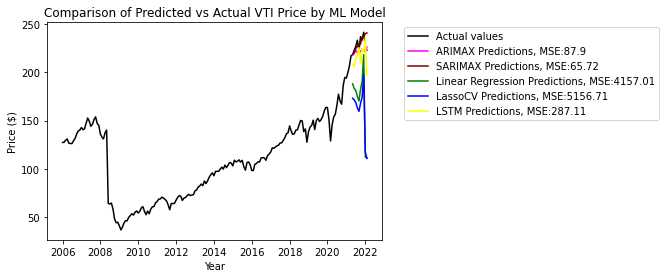

In [6]:
# plot all model predictions
# plt.plot(y_train, label='train')
# plt.plot(y_test, label='test')
plt.plot(y, c='black', label='Actual values')
plt.plot(arimax_results, c='magenta', label=f'ARIMAX Predictions, MSE:{round(arimax_error, 2)}')
plt.plot(sarimax_results, c='maroon', label=f'SARIMAX Predictions, MSE:{round(sarimax_error, 2)}')
plt.plot(lr_results, c='green', label=f'Linear Regression Predictions, MSE:{round(lr_error, 2)}')
plt.plot(lassocv_results, c='blue', label=f'LassoCV Predictions, MSE:{round(lassocv_error, 2)}')
plt.plot(lstm_results, c='yellow', label=f'LSTM Predictions, MSE:{round(lstm_error, 2)}')
plt.title('Comparison of Predicted vs Actual VTI Price by ML Model')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.show()